## SECTION 1: Exploratory Data Analysis (EDA)

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### 1. Load and clean data

In [140]:
def read_data(path_to_csv_file, delimiter=None):
    '''
    Reads csv file from specified path
    '''
    df = pd.read_csv(path_to_csv_file, delimiter=delimiter)
    
    return df

# call function to import data 
patient_df = read_data('/Users/mncedisimncwabe/Downloads/patient_behavior_data.csv',delimiter=";")

In [141]:
# View snapshot of the data
def df_snapshot(df):
    '''
    Returns top 5 rows of the dataframe.
    '''
    return display(df.head())

print(f'patient_df:')
df_snapshot(patient_df)

patient_df:


,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes
0,1,Other,Adderall,15mg,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects...
1,2,Other,NaN,NaN,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed. Ye...
2,3,Male,Vyvanse,15mg,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up. Both set T...
3,4,Female,NaN,5mg,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...
4,5,Female,Vyvanse,30mg,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite. Large sig...


In [6]:
# Check unique patients compared to the data size
print("Data size:", patient_df.shape)
print("Unique patients count:",patient_df['patient_id'].nunique())

Data size: (19999, 19)
Unique patients count: 19999


In [7]:
print("\nBasic statistics:")
display(patient_df.describe())


Basic statistics:


,patient_id,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000
mean,10000.000000,28.502285,79.802030,1.700239,115.033652,74.957798,0.000950,-0.015601,0.016201,-0.006100,0.005750,-0.002900,0.014651
std,5773.358353,10.343832,23.113742,0.173003,14.775816,8.928745,1.415645,1.408884,1.418957,1.410057,1.412698,1.413574,1.417793
min,1.000000,10.100000,40.000000,1.400000,90.000000,60.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,5000.500000,20.500000,59.700000,1.550000,102.000000,67.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,10000.000000,27.300000,79.700000,1.700000,115.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14999.500000,35.000000,99.700000,1.850000,128.000000,83.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,19999.000000,61.100000,120.000000,2.000000,140.000000,90.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [8]:
# Check if all features are in thier correct data types
def data_types(df):
    '''
    Returns datatype of fields in a dataframe.
    '''
    return df.info()

print(f'patient_df:')
data_types(patient_df)

patient_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       19999 non-null  int64  
 1   gender           19999 non-null  object 
 2   medication       16720 non-null  object 
 3   dose             16651 non-null  object 
 4   name             19999 non-null  object 
 5   surname          19999 non-null  object 
 6   bmi              19999 non-null  float64
 7   weight           19999 non-null  float64
 8   height           19999 non-null  float64
 9   systolic         19999 non-null  int64  
 10  diastolic        19999 non-null  int64  
 11  concentration    19999 non-null  int64  
 12  distractibility  19999 non-null  int64  
 13  impulsivity      19999 non-null  int64  
 14  hyperactivity    19999 non-null  int64  
 15  sleep            19999 non-null  int64  
 16  mood             19999 non-null  int64  
 17  

In [142]:
# Check if there are any missing records in the data
def null_checker(df):
    '''
    Returns the count of rows found in the data frame where there is a null present.
    '''
    row_count = len(df)
    null_counts = df.isnull().sum().sort_values(ascending=False)
    null_percentages = (null_counts / row_count) * 100
    combined = pd.concat([null_counts, null_percentages], axis=1, keys=['Null Count', 'Null Percentage'])
    combined['Row Count'] = row_count
    print(combined)

print(f'patient_df:')
null_checker(patient_df)

patient_df:
                 Null Count  Null Percentage  Row Count
dose                   3348        16.740837      19999
medication             3279        16.395820      19999
patient_id                0         0.000000      19999
concentration             0         0.000000      19999
appetite                  0         0.000000      19999
mood                      0         0.000000      19999
sleep                     0         0.000000      19999
hyperactivity             0         0.000000      19999
impulsivity               0         0.000000      19999
distractibility           0         0.000000      19999
systolic                  0         0.000000      19999
diastolic                 0         0.000000      19999
gender                    0         0.000000      19999
height                    0         0.000000      19999
weight                    0         0.000000      19999
bmi                       0         0.000000      19999
surname                   0         

- Some records (16%) for some patients have None/missing records for medication but have values for dose or have None for both medication and dose. This may be data quality issue. For this assessment, I will flag these as "Not Specified" but for a production, I'd investigate why medication is missing when dose exists or vice versa.
- I chose to mark these as 'Not specified' rather than dropping them because 16% is a significant portion, this preserves the dose information which might still be analytically valuable
- I will then extract the numerical value from dose and fill in its missing values with median

In [143]:
# Replace "None" records with "Not Specified"
def replace_missing_with_none(df, column_names):
    '''
    Replace missing values in the specified columns with None.
    '''

    for column_name in column_names:
        if column_name in df.columns:
            df[column_name] = df[column_name].where(df[column_name].notna(), "Not Specified")
        else:
            raise ValueError(f"Column '{column_name}' not found in DataFrame.")
    return df

patient_df_clean = replace_missing_with_none(patient_df, ['medication'])

print(f'Cleaned df:')
df_snapshot(patient_df_clean)
print(f'Check missingness after cleaning:')
null_checker(patient_df_clean)

Cleaned df:


,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes
0,1,Other,Adderall,15mg,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects...
1,2,Other,Not Specified,NaN,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed. Ye...
2,3,Male,Vyvanse,15mg,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up. Both set T...
3,4,Female,Not Specified,5mg,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...
4,5,Female,Vyvanse,30mg,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite. Large sig...


Check missingness after cleaning:
                 Null Count  Null Percentage  Row Count
dose                   3348        16.740837      19999
patient_id                0         0.000000      19999
diastolic                 0         0.000000      19999
appetite                  0         0.000000      19999
mood                      0         0.000000      19999
sleep                     0         0.000000      19999
hyperactivity             0         0.000000      19999
impulsivity               0         0.000000      19999
distractibility           0         0.000000      19999
concentration             0         0.000000      19999
systolic                  0         0.000000      19999
gender                    0         0.000000      19999
height                    0         0.000000      19999
weight                    0         0.000000      19999
bmi                       0         0.000000      19999
surname                   0         0.000000      19999
name          

In [145]:
# Now extract the numerical value from dose and fill the missing values with median. eg 15mg will be 15
def clean_and_fill_dose(df, dose_column='dose'):
    def extract_dose_value(dose):
        if pd.isna(dose):
            return None
        return float(dose.rstrip('mg'))

    df['dose'] = df[dose_column].apply(extract_dose_value)

    # fill in missing dose values with median
    median_dose = df['dose'].median()
    df['dose'].fillna(median_dose, inplace=True)

    return df

patient_df_clean = clean_and_fill_dose(patient_df_clean)
null_checker(patient_df_clean)
patient_df_clean.head()

                 Null Count  Null Percentage  Row Count
patient_id                0              0.0      19999
diastolic                 0              0.0      19999
appetite                  0              0.0      19999
mood                      0              0.0      19999
sleep                     0              0.0      19999
hyperactivity             0              0.0      19999
impulsivity               0              0.0      19999
distractibility           0              0.0      19999
concentration             0              0.0      19999
systolic                  0              0.0      19999
gender                    0              0.0      19999
height                    0              0.0      19999
weight                    0              0.0      19999
bmi                       0              0.0      19999
surname                   0              0.0      19999
name                      0              0.0      19999
dose                      0              0.0    

,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes
0,1,Other,Adderall,15.0,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects...
1,2,Other,Not Specified,15.0,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed. Ye...
2,3,Male,Vyvanse,15.0,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up. Both set T...
3,4,Female,Not Specified,5.0,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...
4,5,Female,Vyvanse,30.0,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite. Large sig...


##### Clean doctor notes field
- The sentences after the first one on the doctor notes field appears do not make sense and seems to be placeholder text. We need to clean these notes by keeping only the first meaningful sentence.

In [146]:
def clean_clinical_notes(text):
    """
    Keep only the first coherent sentence from doctor notes.
    Removes all text after the first period followed by space and capital letter.
    """
    if pd.isna(text):
        return ""
    
    # Find the first sentence-ending period followed by space and capital letter
    match = re.search(r'\.\s+[A-Z]', str(text))
    
    if match:
        return text[:match.start()+1].strip()
    else:
        return str(text).strip()

patient_df_clean['doctor_notes'] = patient_df_clean['doctor_notes'].apply(clean_clinical_notes)
patient_df_clean.head()


,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes
0,1,Other,Adderall,15.0,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects.
1,2,Other,Not Specified,15.0,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed.
2,3,Male,Vyvanse,15.0,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up.
3,4,Female,Not Specified,5.0,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...
4,5,Female,Vyvanse,30.0,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite.


#### 2. Summarise key metrics:
- BMI, blood pressure by gender and medication.
- Distribution of behavioural ratings (-2 to 2).


#### Insights
##### BMI
- BMI measurements are fairly consistent across genders, with medians around 27.1-27.3 and mean around 28 from all genders. This means that 50% (9000+) of the patients are overweight (25.0-29.9 BMI).
- Based on the upper quartile (Q3) BMI across all genders, 25% (4000+) of the patients have BMI above BMI > 34-35 which falls within the obese range (30-34)
- The median BMI for all medical groups fall within 34-35 range, which means that 50% of patients in all medication groups fall within the overweight range (25–29.9 BMI)
- Ritalin, Concerta and Strattera are associated with the highest severe obesity rates.

##### Blood Pressure
- Median systolic blood pressure (115 mmHg) and distolic (75 mmHg) are consistent for all genders.
- Q3 of 128 mmHg for systolic and 83 for diastolic for all genders, which means that 25% of patients falls into the "elevated blood pressure" category. This means the blood pressure is higher than normal but not yet considered Stage 1 hypertension. The same applies to the medicaiton group.

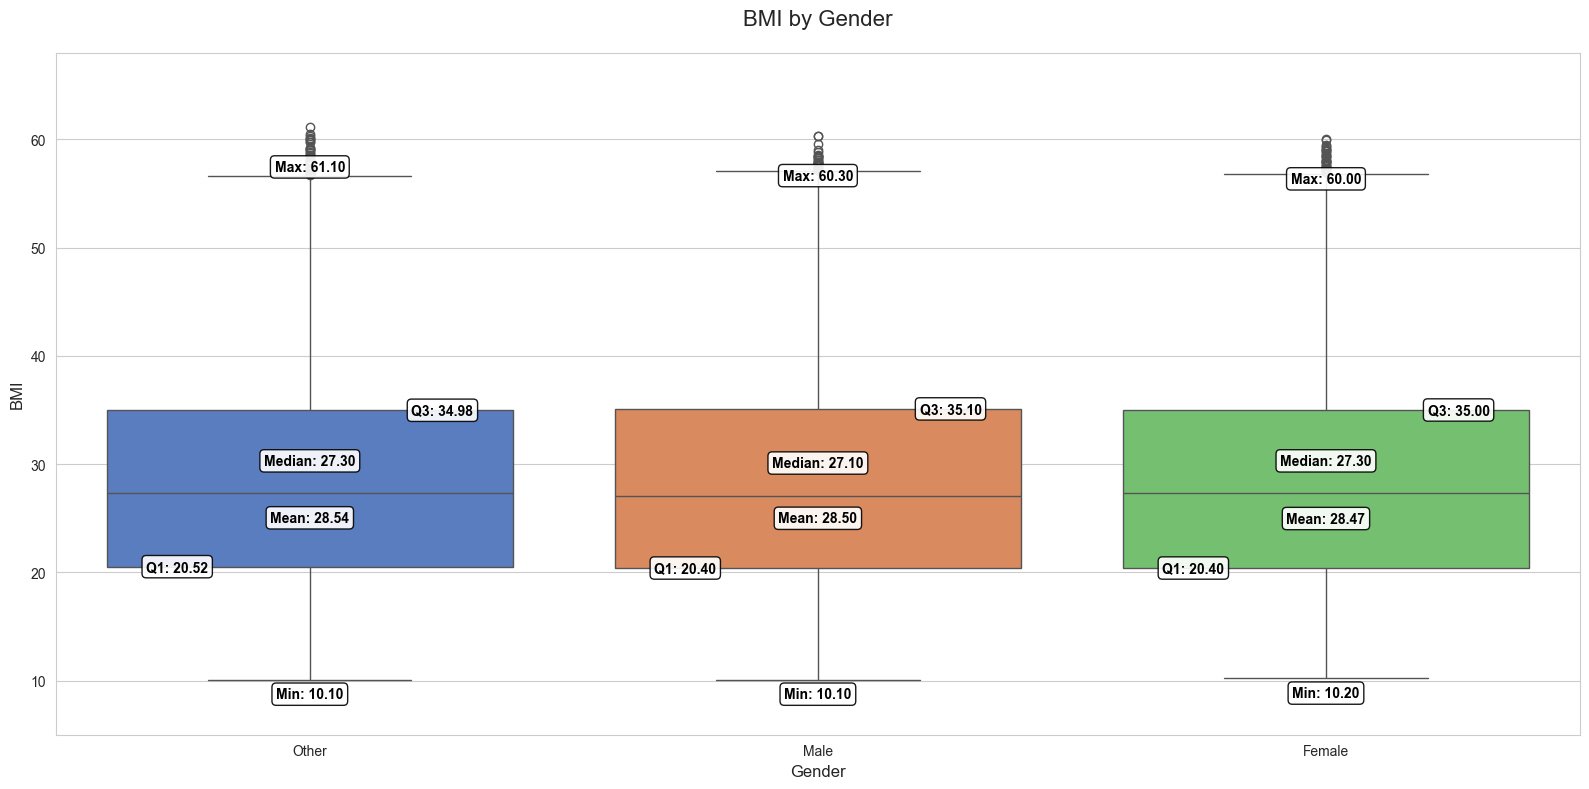

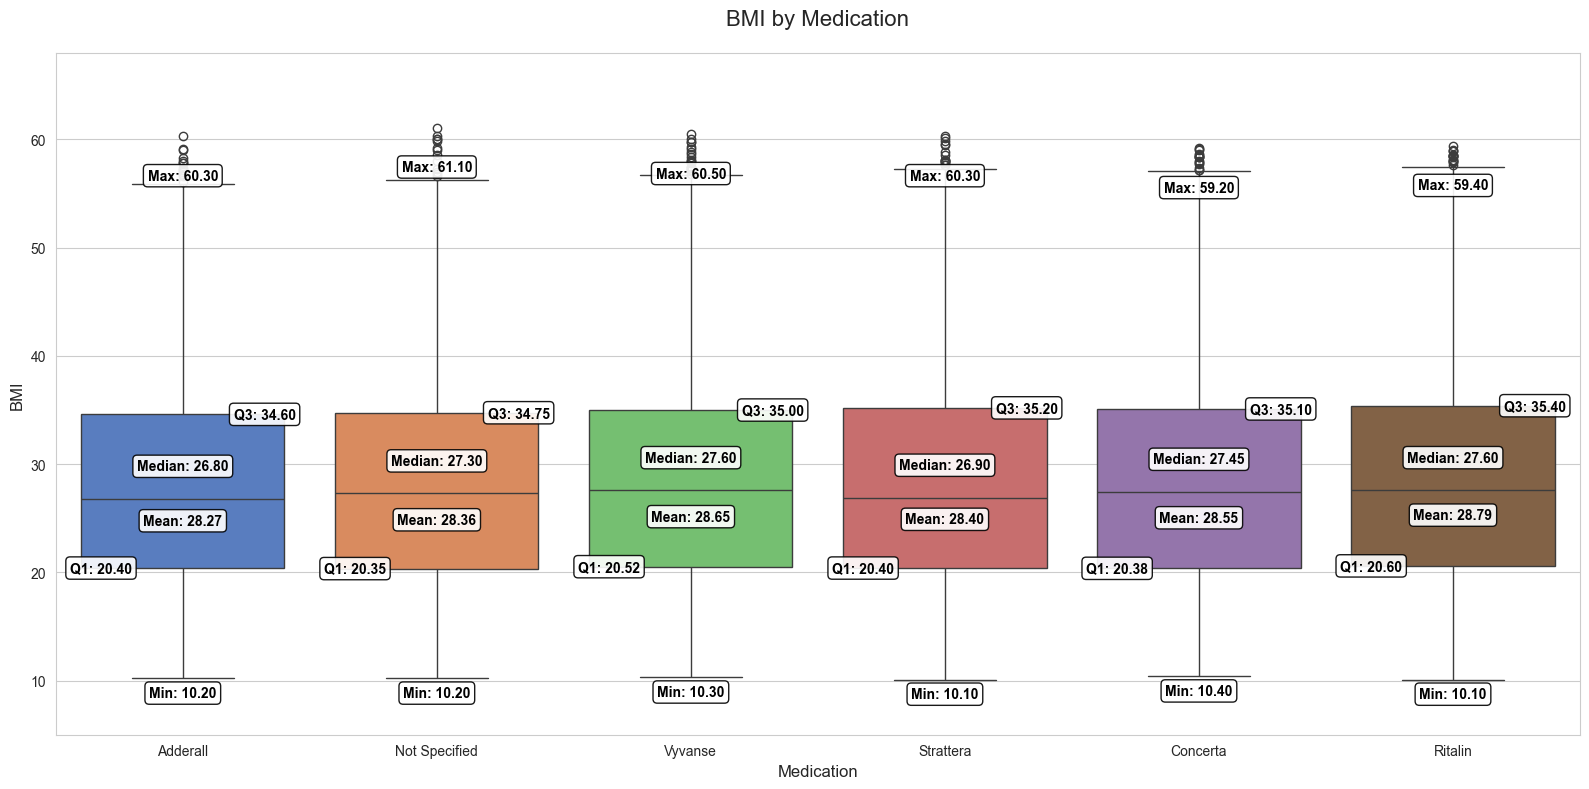

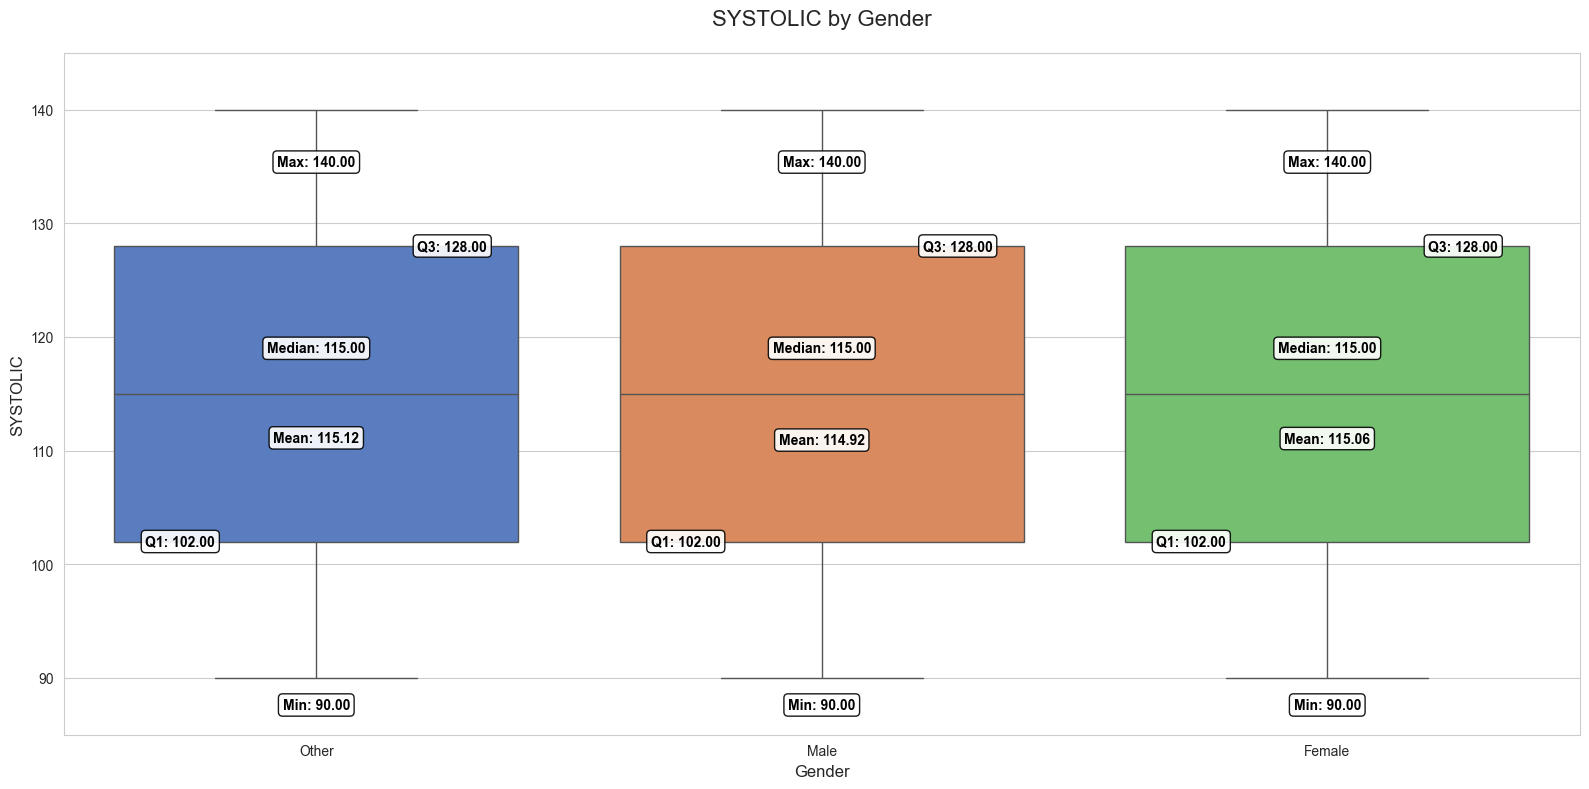

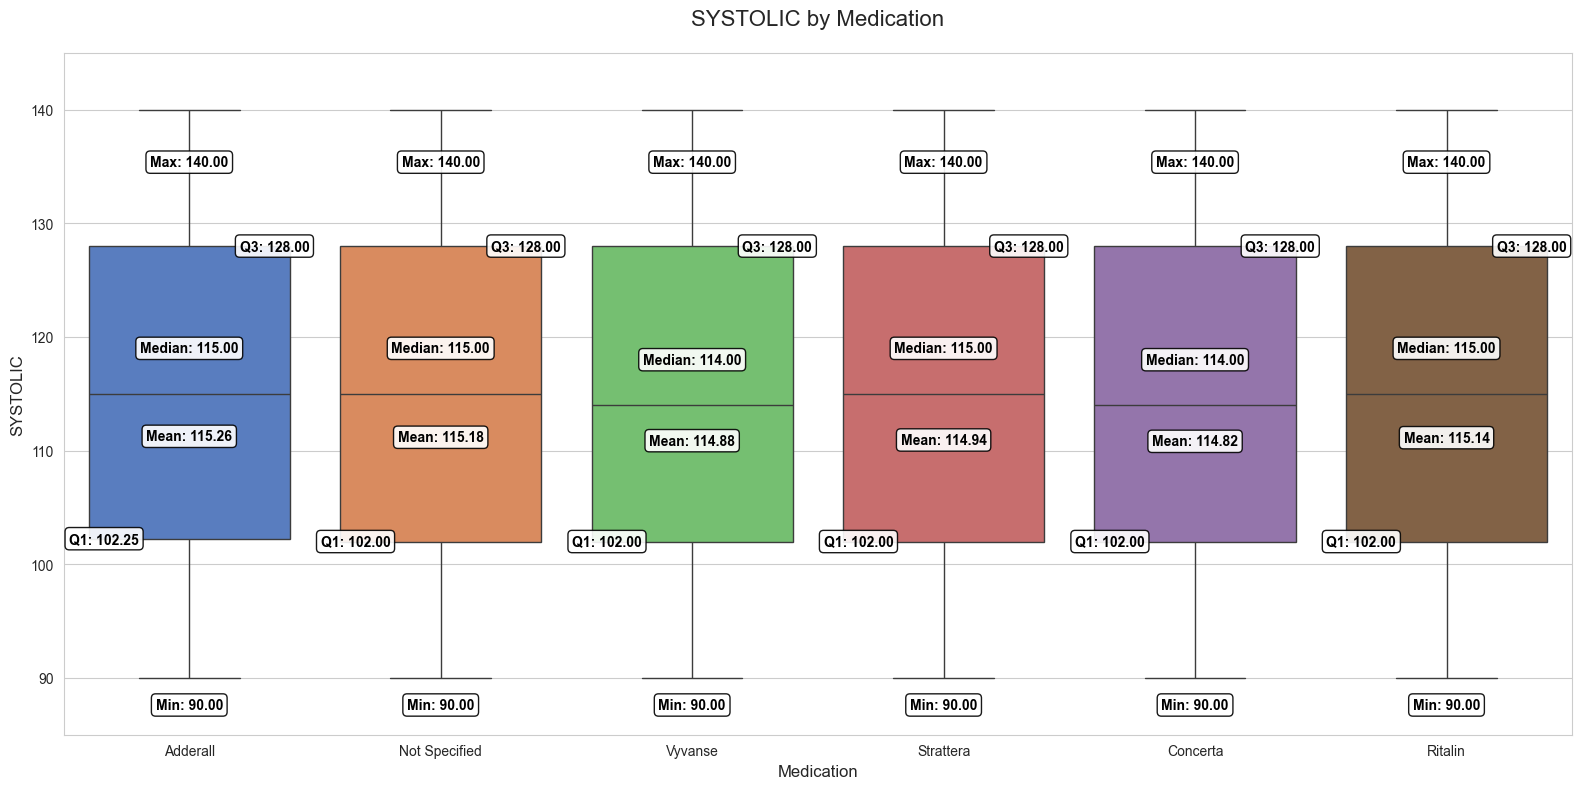

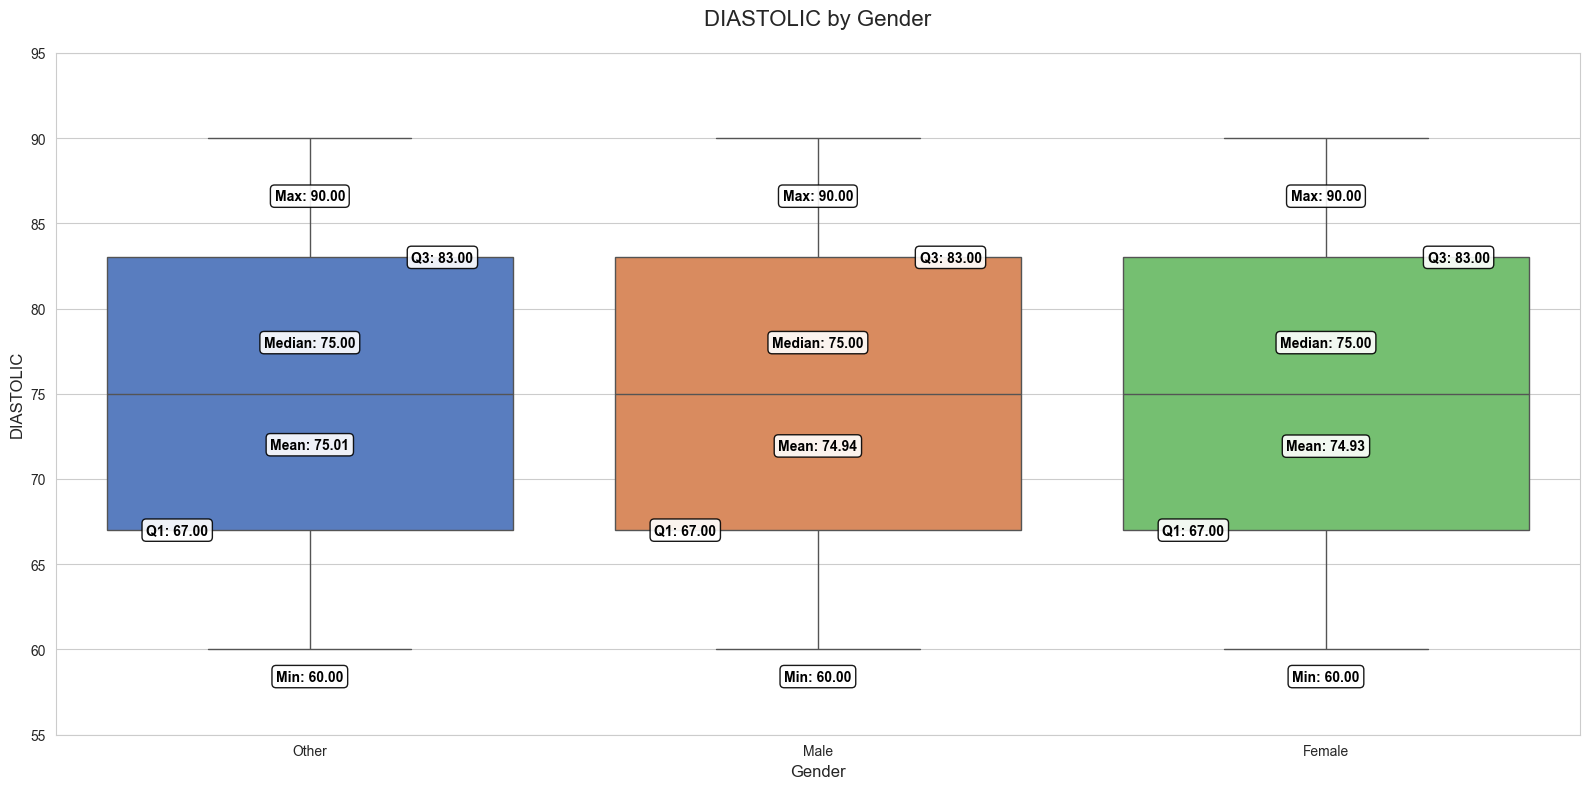

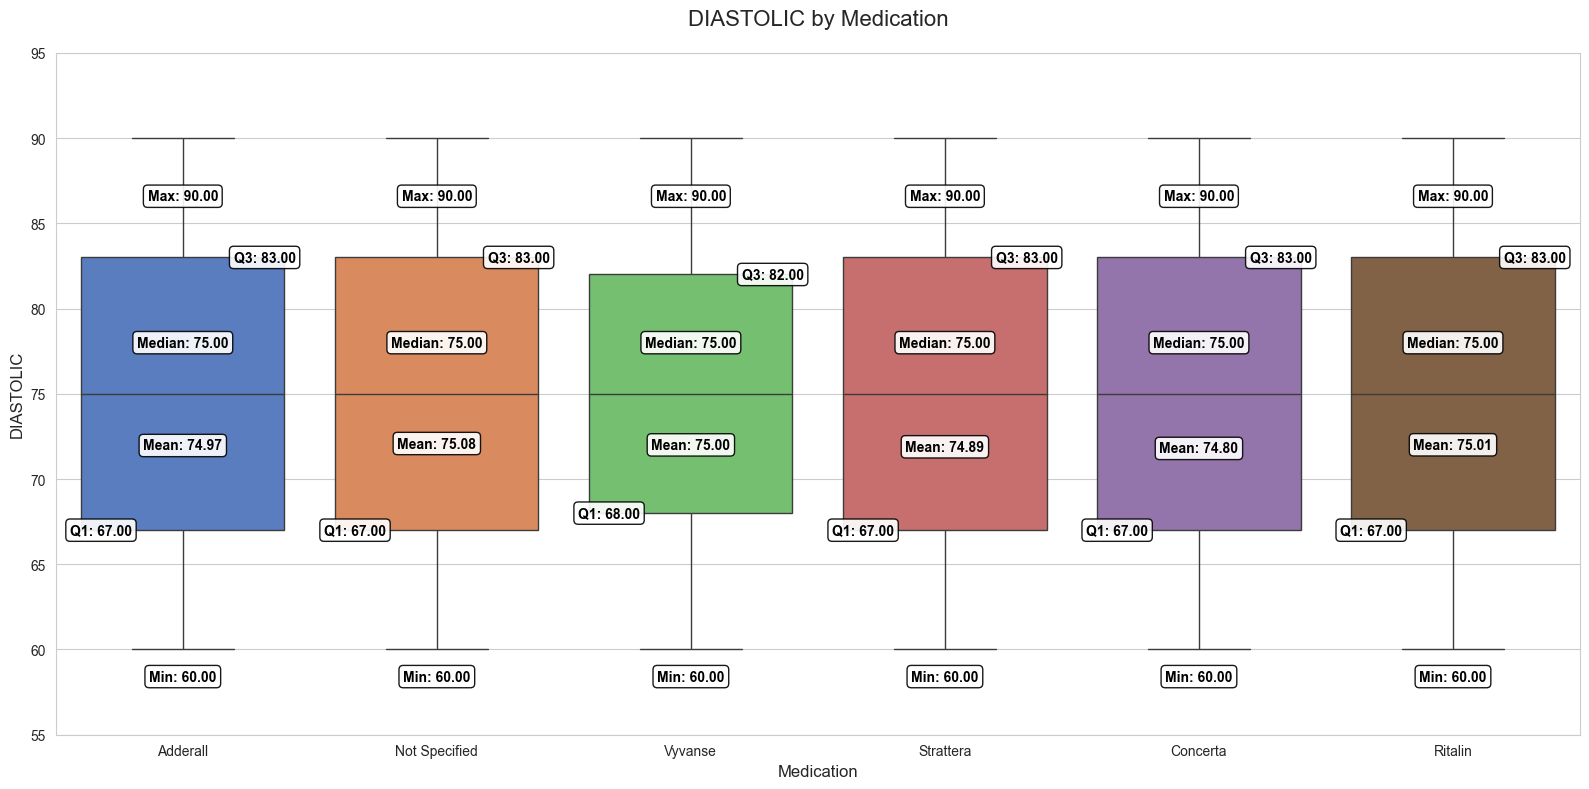

In [147]:
def plot_health_metrics(df, metrics=['bmi', 'systolic', 'diastolic'], categories=['gender', 'medication']):
    sns.set_style("whitegrid")
    palette = sns.color_palette("muted")
    # metric settings
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1, alpha=0.9)
    metric_settings = {
        'bmi': {
            'range': (5, 68),
            'offsets': (-2, -3),
            'text_positions': (-3.5, 3)
        },
        'systolic': {
            'range': (85, 145),  
            'offsets': (-3, -4),
            'text_positions': (-4, 4)
        },
        'diastolic': {
            'range': (55, 95),  
            'offsets': (-2, -3),
            'text_positions': (-3, 3)
        }
    }
    
    # combinations of metrics and categories
    combinations = [(metric, factor) for metric in metrics for factor in categories]
    
    for metric, factor in combinations:
        plt.figure(figsize=(16, 8))
        ax = sns.boxplot(x=factor, y=metric, data=df, palette=palette)
        plt.title(f'{metric.upper()} by {factor.capitalize()}', fontsize=16, pad=20)
        
        settings = metric_settings.get(metric, {
            'range': (None, None),
            'offsets': (-3, -4),
            'text_positions': (-4, 4)
        })
        
        plt.ylim(*settings['range'])
        
        # Calculate the statistics for each specified categorical column
        categories = df[factor].unique()
        
        for category in categories:
            cat_data = df[df[factor] == category][metric]
            min_val = np.min(cat_data)
            q1 = np.percentile(cat_data, 25)
            median = np.percentile(cat_data, 50)
            q3 = np.percentile(cat_data, 75)
            max_val = np.max(cat_data)
            mean_val = np.mean(cat_data)
            x_pos = list(categories).index(category)
            min_offset, max_offset = settings['offsets']
            mean_text_y, median_text_y = settings['text_positions']

            # Min value
            ax.annotate(f'Min: {min_val:.2f}', xy=(x_pos, min_val), xytext=(x_pos, min_val + min_offset), 
                        ha='center', va='bottom', color='black', fontweight='bold', bbox=bbox_props)

            # Q1 value
            ax.annotate(f'Q1: {q1:.2f}', xy=(x_pos, q1), xytext=(x_pos - 0.2, q1), ha='right', 
                        va='center', color='black', fontweight='bold', bbox=bbox_props)

            # Median value
            ax.annotate(f'Median: {median:.2f}', xy=(x_pos, median), xytext=(x_pos, median + median_text_y),
                        ha='center', va='center', color='black', fontweight='bold', bbox=bbox_props)

            # Mean value
            ax.annotate(f'Mean: {mean_val:.2f}', xy=(x_pos, mean_val), xytext=(x_pos, mean_val + mean_text_y), 
                        ha='center', va='center', color='black', fontweight='bold', bbox=bbox_props)

            # Q3 value
            ax.annotate(f'Q3: {q3:.2f}', xy=(x_pos, q3), xytext=(x_pos + 0.2, q3), ha='left', 
                        va='center', color='black', fontweight='bold', bbox=bbox_props)

            # Max value
            ax.annotate(f'Max: {max_val:.2f}', xy=(x_pos, max_val), xytext=(x_pos, max_val + max_offset), 
                        ha='center', va='top', color='black', fontweight='bold', bbox=bbox_props)

        plt.ylabel(metric.upper(), fontsize=12)
        plt.xlabel(factor.capitalize(), fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()

plot_health_metrics(patient_df_clean)

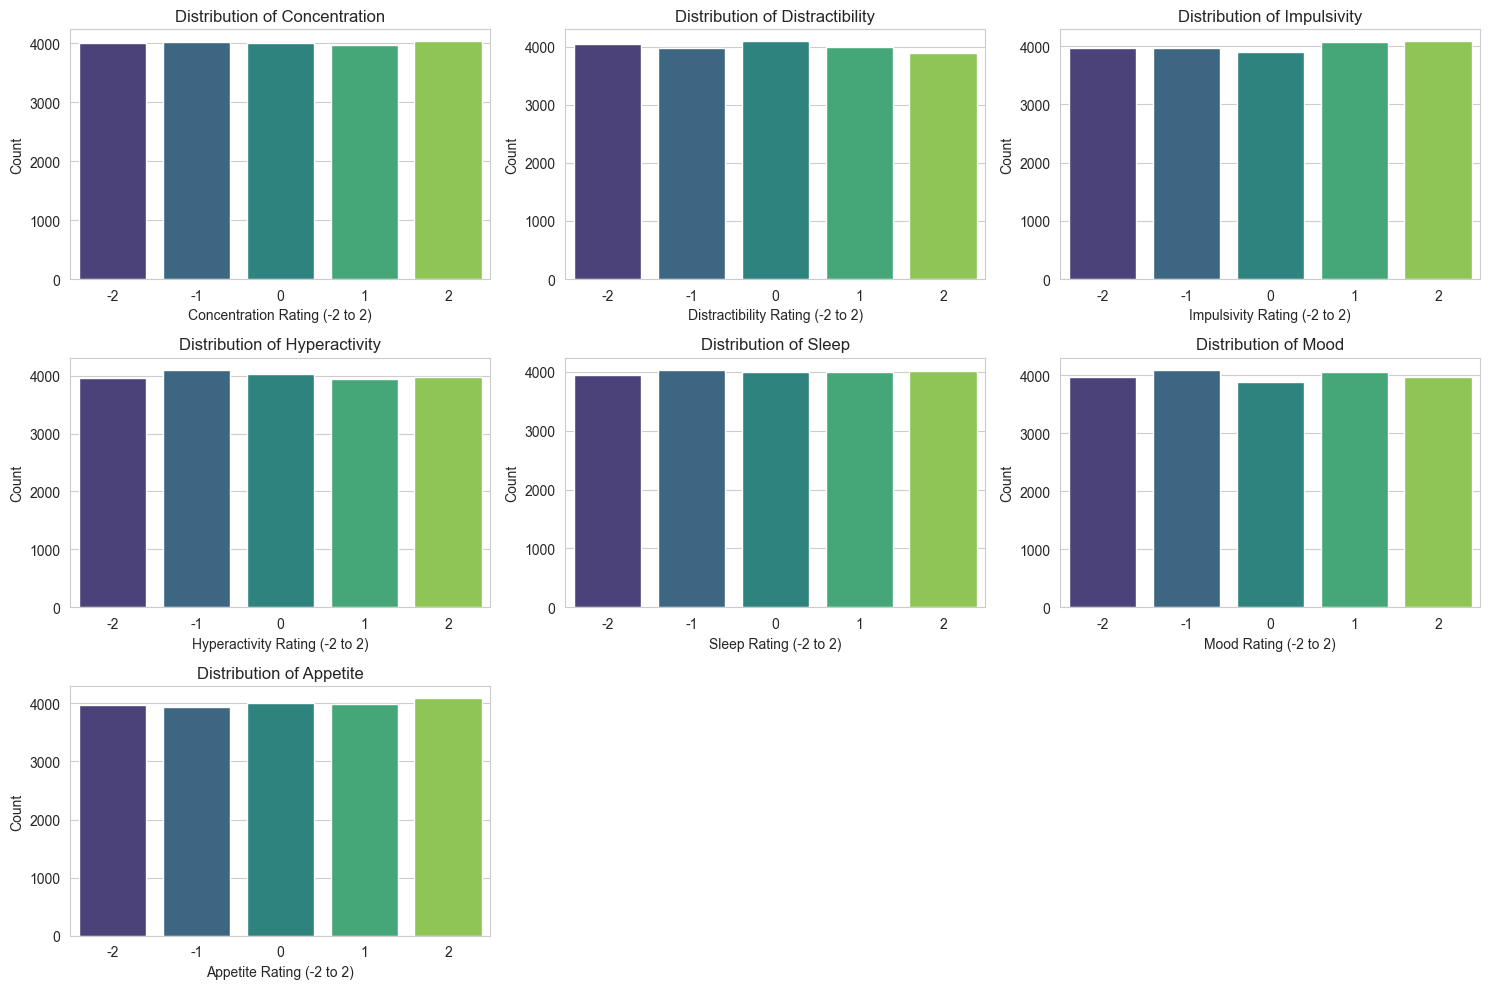

In [148]:
# Distribution of Behavioral Ratings
behavior_cols = ['concentration', 'distractibility', 'impulsivity', 'hyperactivity', 
                 'sleep', 'mood', 'appetite']

plt.figure(figsize=(15, 10))
for i, col in enumerate(behavior_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=patient_df_clean[col], palette='viridis')
    plt.title(f'Distribution of {col.capitalize()}')
    plt.xlabel(f'{col.capitalize()} Rating (-2 to 2)')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

### 3. Visualisations:
- Correlation heatmap between behaviour fields.
- Boxplot: concentration vs medication.
- Scatter plot: BMI vs systolic, coloured by hyperactivity.


#### Insights

The behaviorial ratings features (-2 to 2 ) are ordinal data, they represent ranked categories (ratings), so I used Spearman’s ρ (rank correlation) for correlation because it considers the order of values, not their absolute magnitudes, making it robust for non-linear but monotonic relationships.

- The correlation matrix shows that all the correlation coefficients are very close to zero (around 0.01 or -0.01), this suggests that a patient's ranking in one behavioral trait (e.g., concentration) is generally not predictive of their ranking in another trait (e.g., mood). These behavioral features appear to be independent of each other within this patient group.


- The boxplot for concentration vs medication shows that all medications (Adderall, Vyvanse, Strattera, Concerta, and Ritalin) show similar median concentration rating around 0. The consistency across medications suggests that in this dataset, no single medication demonstrates clearly superior effects on concentration rating.
-  The scatter plot for BMI vs systolic by hyperactivity, shows that there is no strong linear correlation between BMI and systolic blood pressure visible in this data. The data points are distributed fairly evenly across the graph, suggesting diverse patient profiles. The absence of clear patterns suggest that individual patient responses to medications are variable, reinforcing the need for personalized treatment approaches.

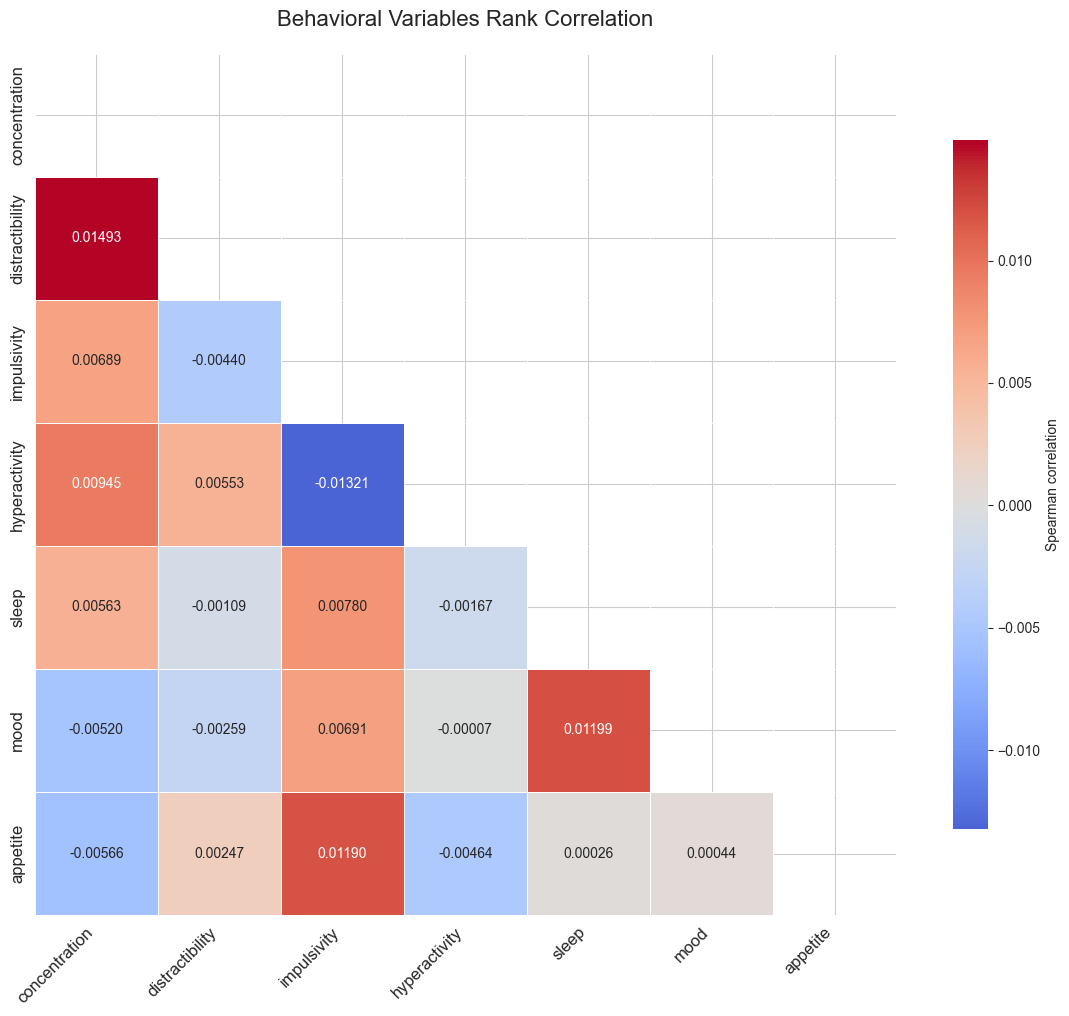

In [149]:
# Correlation heatmap between behaviour fields.
def plot_spearman_heatmap(df, behavior_cols):
    """
    Plot Spearman's rank correlation heatmap for behavioral variables (-2 to 2 scale).

    """
    df_behaviors = df[behavior_cols]
    corr_matrix = np.zeros((len(behavior_cols), len(behavior_cols)))
    p_matrix = np.zeros((len(behavior_cols), len(behavior_cols)))
    
    for i, col1 in enumerate(behavior_cols):
        for j, col2 in enumerate(behavior_cols):
            corr_matrix[i, j], p_matrix[i, j] = spearmanr(df_behaviors[col1], df_behaviors[col2])

    corr_df = pd.DataFrame(corr_matrix, index=behavior_cols, columns=behavior_cols)
    p_df = pd.DataFrame(p_matrix, index=behavior_cols, columns=behavior_cols)
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    
    ax = sns.heatmap(corr_df,mask=mask,cmap='coolwarm',center=0,annot=True,fmt=".5f",square=True,
        linewidths=.5,cbar_kws={"shrink": .8, "label": "Spearman correlation"},annot_kws={"size": 10})
    
    plt.title("Behavioral Variables Rank Correlation",pad=20,fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

behavior_cols = ['concentration', 'distractibility', 'impulsivity', 'hyperactivity', 'sleep', 'mood', 'appetite']
plot_spearman_heatmap(patient_df_clean, behavior_cols)

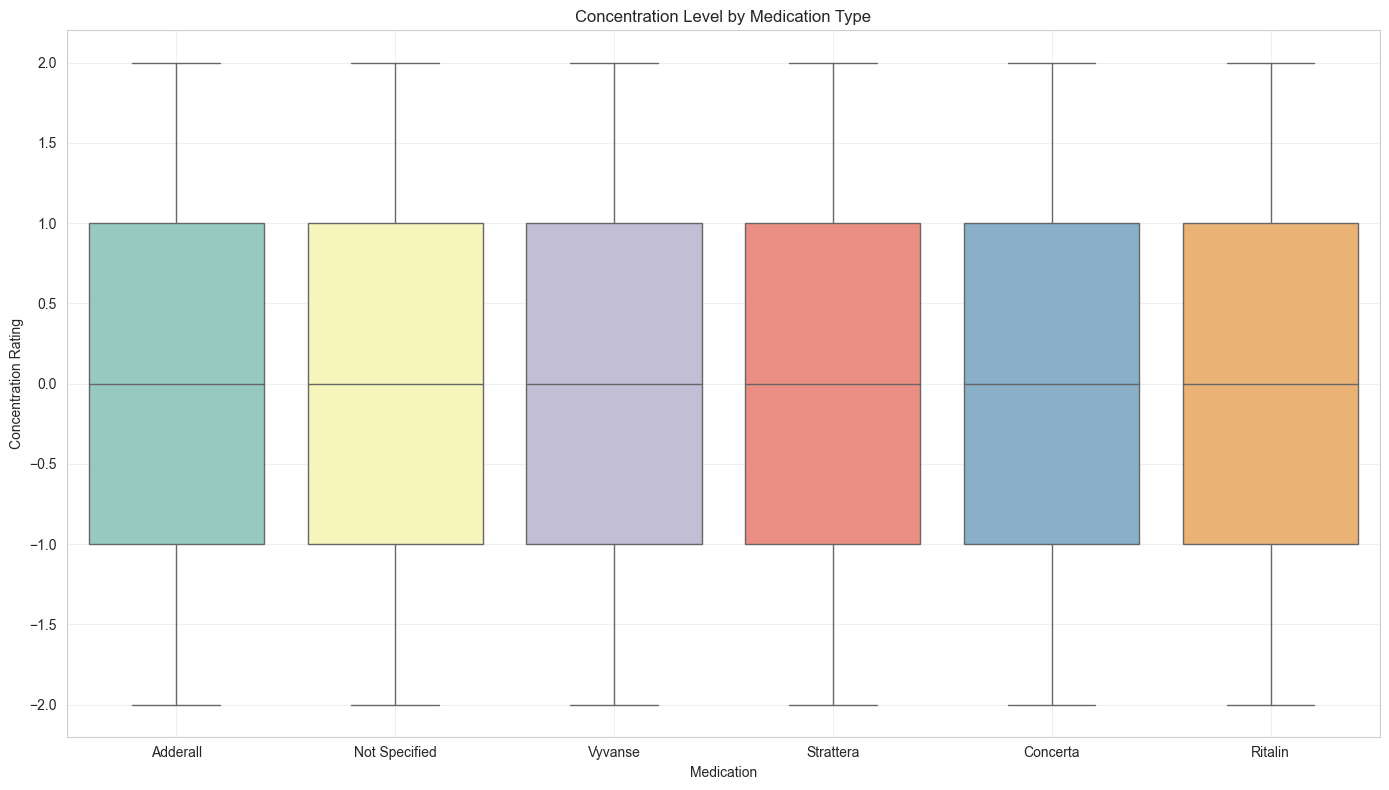

In [150]:
# Boxplot: concentration vs medication
plt.figure(figsize=(14, 8))
sns.boxplot(x='medication', y='concentration', data=patient_df_clean, palette='Set3')
plt.title('Concentration Level by Medication Type')
plt.xlabel('Medication')
plt.ylabel('Concentration Rating')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

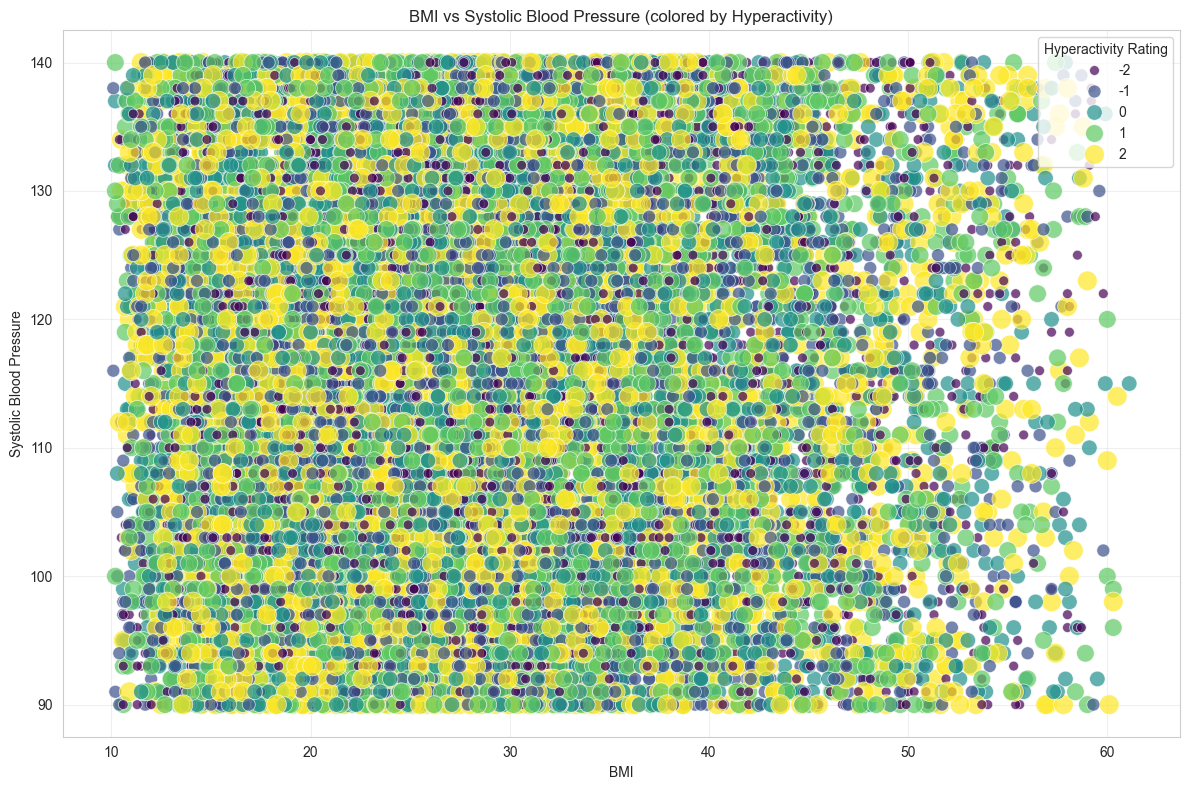

In [151]:
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x='bmi', y='systolic', hue='hyperactivity', 
                          data=patient_df_clean, palette='viridis', size='hyperactivity',
                          sizes=(50, 200), alpha=0.7)
plt.title('BMI vs Systolic Blood Pressure (colored by Hyperactivity)')
plt.xlabel('BMI')
plt.ylabel('Systolic Blood Pressure')
plt.grid(True, alpha=0.3)
plt.legend(title='Hyperactivity Rating')
plt.tight_layout()
plt.show()

#### Insights from the doctor's notes

- Bsed on the wordcloud visual analysis on doctor's notes, core ADHD symptoms are prominently featured: "trouble sitting," "minute," "following multi," "low," "difficulty following," and "impulsivity" stand out clearly.
- Patient behavior descriptors are common: terms like "often restless," "fidgety" and "cooperative" suggest doctors are tracking behavioral patterns.
- The inability to sit still and maintain focus for even short periods ("few minutes") appears to be the most commonly documented concern.
- The frequency of "following multi step" suggests specific difficulties with sequential processing and function.

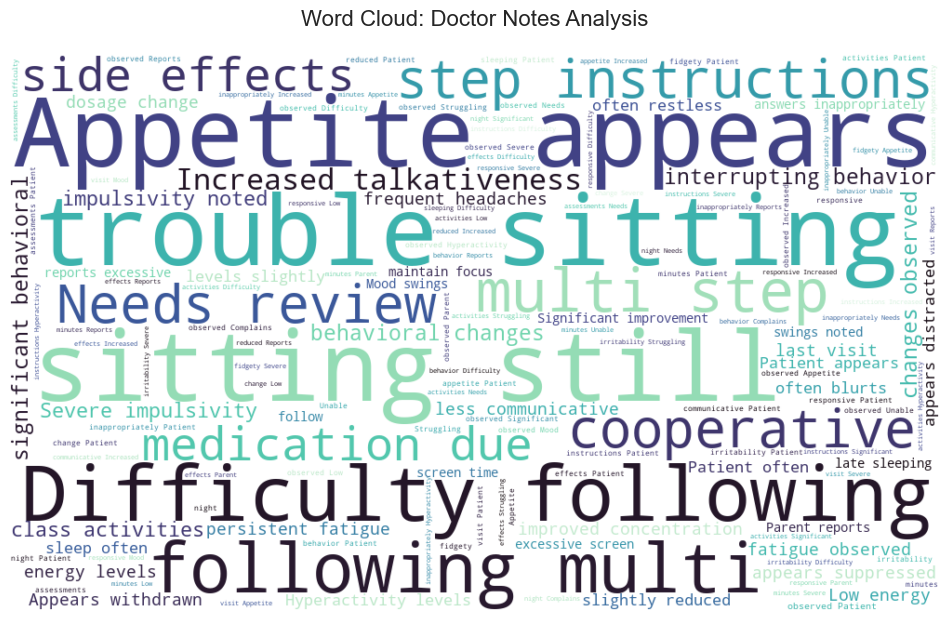

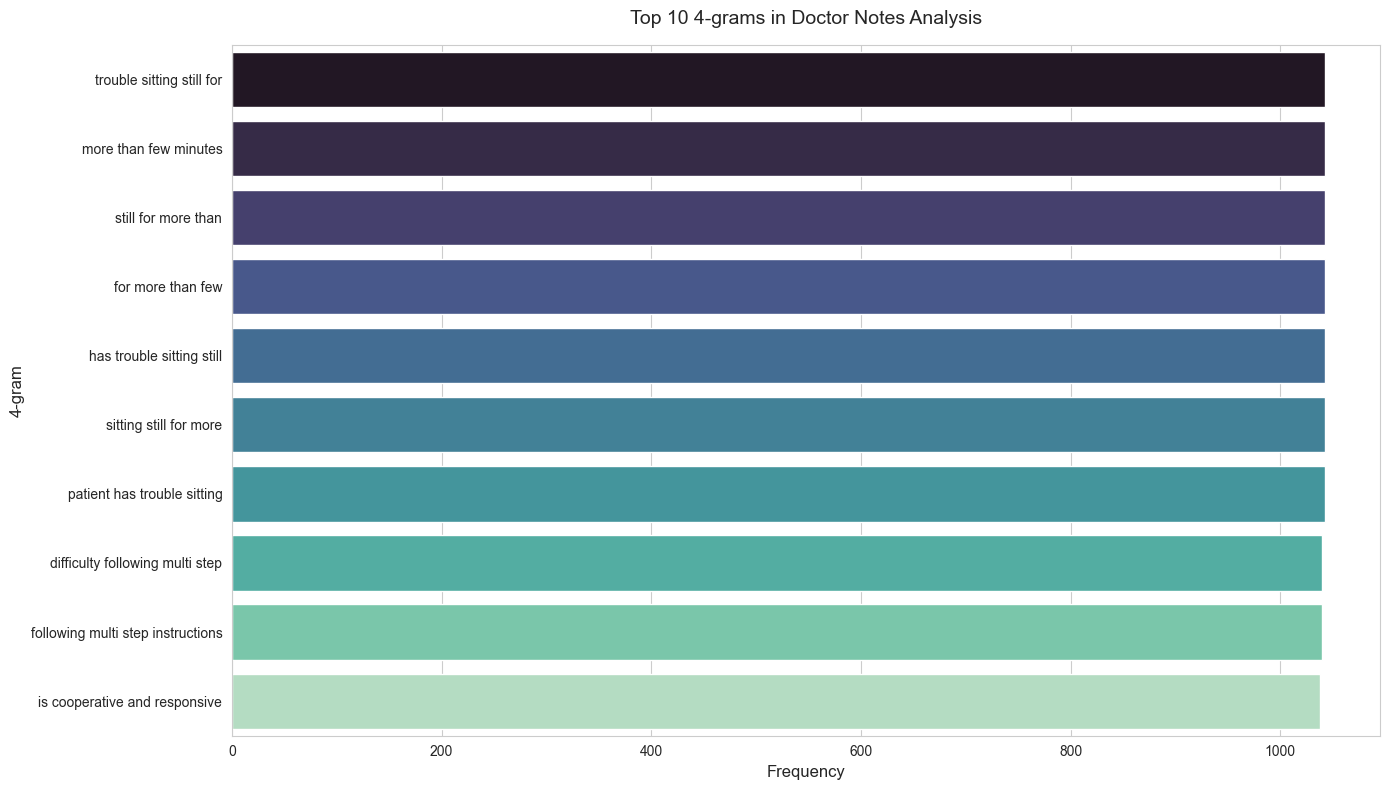

In [152]:
def perform_text_eda(df):
    """
    Perform exploratory data analysis on text fields with word clouds and n-grams
    """
    # Wordcloud Analysis on doctor notes field
    analysis_groups = {
        'doctor_notes': {
            'title': "Doctor Notes Analysis",
            'color': 'mako',
            'top_n': 20
        }
    }
    for field in analysis_groups.keys():
        if field in df.columns:
            text = " ".join(df[field].astype(str))
            plt.figure(figsize=(12, 8))
            wc = WordCloud(width=1000, 
                          height=600, 
                          background_color='white',
                          colormap=analysis_groups[field]['color'],
                          max_words=150).generate(text)
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Word Cloud: {analysis_groups[field]['title']}", pad=20, fontsize=16)
            plt.show()
    
    # N-gram Analysis (4-grams)
    ngram_fields = ['doctor_notes']
    for field in ngram_fields:
        if field in df.columns:
            vec = CountVectorizer(ngram_range=(4, 4), max_features=20)
            X = vec.fit_transform(df[field].astype(str))
            fourgrams = pd.DataFrame(X.sum(axis=0), 
                                   columns=vec.get_feature_names_out()).T.sort_values(0, ascending=False)
            
            plt.figure(figsize=(14, 8))
            if not fourgrams.empty:
                sns.barplot(x=fourgrams[0][:10], 
                           y=fourgrams.index[:10], 
                           palette=analysis_groups[field]['color'])
                plt.title(f"Top 10 4-grams in {analysis_groups[field]['title']}", pad=15, fontsize=14)
                plt.xlabel("Frequency", fontsize=12)
                plt.ylabel("4-gram", fontsize=12)
                plt.tight_layout()
                plt.show()
            else:
                print(f"No 4-grams found for {field}")

perform_text_eda(patient_df_clean)

## SECTION 2: NLP on doctor_notes

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy
import scispacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, classification_report, ConfusionMatrixDisplay
from mord import OrdinalRidge
from sklearn.model_selection import GridSearchCV

# model explanations
import lime
from lime.lime_text import LimeTextExplainer
import shap

In [3]:
#pip install numpy==1.26

### 1. Preprocess notes: tokenise, lemmatise, remove stopwords.

In [154]:
# Load spaCy's English model
nlp_spacy = spacy.load('en_core_web_sm')

# Keep some custom medical terms stopwords 
MEDICAL_STOPWORDS = {'patient', 'history', 'normal', 'exam', 'physical', 'day', 'week', 'month', 'year', 'status', 'note', 'findings'}
STOP_WORDS.update(MEDICAL_STOPWORDS)

def remove_emojis_special_chars(text):
    """Remove emojis and special characters from text"""
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF" 
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002500-\U00002BEF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\u2640-\u2642" 
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    
    text = re.sub(r'[^\w\s.,!?]', '', text)
    return emoji_pattern.sub(r'', text)

def preprocess_text(text):
    """
    Preprocess clinical notes by:
    1. Removing emojis/special characters
    2. Tokenizing
    3. Lemmatizing 
    4. Removing stopwords (while preserving medical terms)
    """
    if pd.isna(text):
        return ""
    
    # lower case text
    cleaned_text = remove_emojis_special_chars(str(text).lower())
    
    # tokenization 
    doc = nlp_spacy(cleaned_text)
    
    processed_tokens = []
    for token in doc: 
        if (not token.is_punct and 
            not token.is_space and 
            (not token.is_stop or token.text in MEDICAL_STOPWORDS)):
            
            # lemmatization
            lemma = token.lemma_.strip().lower()
            if lemma:  
                processed_tokens.append(lemma)
    
    return " ".join(processed_tokens)

patient_df_processed = patient_df_clean.copy()
patient_df_processed['processed_notes'] = patient_df_processed['doctor_notes'].apply(preprocess_text)
patient_df_processed.head()

,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes,processed_notes
0,1,Other,Adderall,15.0,Ashley,Merritt,26.8,82.9,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects.,need review medication effect
1,2,Other,Not Specified,15.0,Joseph,Salazar,17.3,52.3,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed.,significant behavioral change observe
2,3,Male,Vyvanse,15.0,Barbara,Roberts,35.5,114.9,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up.,mood swing note followup
3,4,Female,Not Specified,5.0,Dawn,Brown,36.5,91.2,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...,increase talkativeness interrupt behavior
4,5,Female,Vyvanse,30.0,Robert,Warner,17.7,40.4,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite.,significant improvement appetite


### 2. Use NER (spaCy or scispaCy) to extract medical terms.

In [155]:
# Download BC5CDR model (chemical/disease NER)
# pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz

# Load the BC5CDR model (chemical/disease NER)
nlp = spacy.load("en_ner_bc5cdr_md")

def extract_medical_entities(text, visualize=False):
    """
    Extract medical entities using scispacy BC5CDR model
    """
    if pd.isna(text) or not str(text).strip():
        return {'terms': "", 'details': []}
    
    doc = nlp(str(text))
    entities = []
    details = []
    
    for ent in doc.ents:
        entities.append(ent.text)
        details.append((ent.text, ent.label_, ent.start_char, ent.end_char))

    if visualize and doc:
        displacy.render(doc[:400], style='ent', jupyter=True)
    
    return {'terms': " | ".join(set(entities)), 'details': details}

medical_entities = patient_df_processed['processed_notes'].apply(extract_medical_entities)
patient_df_processed['medical_terms'] = medical_entities.apply(lambda x: x['terms'])
patient_df_processed['medical_entities'] = medical_entities.apply(lambda x: x['details'])

# Visualize
extract_medical_entities(patient_df_processed['doctor_notes'].iloc[298], visualize=True)
patient_df_processed[['doctor_notes','processed_notes', 'medical_terms', 'medical_entities']].tail()

,doctor_notes,processed_notes,medical_terms,medical_entities
19994,Unable to maintain focus during assessments.,unable maintain focus assessment,,[]
19995,Low energy levels and persistent fatigue obser...,low energy level persistent fatigue observe,fatigue,"[(fatigue, DISEASE, 28, 35)]"
19996,Hyperactivity levels slightly reduced.,hyperactivity level slightly reduce,hyperactivity,"[(hyperactivity, DISEASE, 0, 13)]"
19997,Patient is cooperative and responsive.,patient cooperative responsive,,[]
19998,Mood swings noted during follow-up.,mood swing note followup,,[]


### 3. Train a model to classify mood from doctor_notes (baseline + explanation).
- Use TF-IDF + Logistic Regression
- Visualise important words using LIME or SHAP


#### Insights
- The target variable mood ratings is ordinal data type (-2 to 2), therefore models for ordinal data can be best suited 

##### Important features/words from model
- Positive moods (2) are associated with improved appetite ("significant improvement appetite") and reduced hyperactivity ("level slightly reduce")
- Neutral moods (0-1): show more medication adjustments ("dosage change")
- Negative moods (-1): correlate with social withdrawal features ("appears withdran and less communicative") and increased hyperactivity
- The models have low accuracy whcih indicates they struggles to reliably predict mood classes. Text-based models often need larger volumes of text data and may need deeper NLP preprocessing.
- For production purpose I'd also try more advanced feature engineering such as transformer-based models (e.g BERT) which understand semantic meaning of a text, but kept it at TF-IDF for the scope of this assessment. 
- For prod I'd also invest in data quality and advanced modeling techniques to improve accuracy, but this serves as a POC with much room for improvement.


In [156]:
def prepare_for_modeling(df):
    vectorizer = TfidfVectorizer(
        max_features=1000,
        ngram_range=(1, 3),
        min_df=3,                      
        max_df=0.85,                   
        stop_words='english',
        analyzer='word',
        use_idf=True,
        sublinear_tf=True
    )
    # Fit and transform
    X = vectorizer.fit_transform(df['processed_notes'])
    y = df['mood']
    
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()

    # Convert to DataFrame while preserving sparsity
    if sparse.issparse(X):
        X_df = pd.DataFrame.sparse.from_spmatrix(X, columns=feature_names)
    else:
        X_df = pd.DataFrame(X, columns=feature_names)
    
    return X_df, y, vectorizer, feature_names

X, y, vectorizer, feature_names = prepare_for_modeling(patient_df_processed)
X.head()

,activity,answer,answer inappropriately,appear,appear distracted,appear distracted fidgety,appear suppress,appear suppress visit,appear withdraw,appear withdraw communicative,appetite,appetite appear,appetite appear suppress,assessment,behavior,behavioral,behavioral change,behavioral change observe,blurt,blurt answer,blurt answer inappropriately,change,change observe,class,class activity,communicative,complain,complain frequent,complain frequent headache,concentration,concentration dosage,concentration dosage change,cooperative,cooperative responsive,difficulty,difficulty follow,difficulty follow multistep,distracted,distracted fidgety,dosage,dosage change,effect,energy,energy level,energy level persistent,excessive,excessive screen,excessive screen time,fatigue,fatigue observe,fidgety,focus,focus assessment,follow,follow multistep,follow multistep instruction,followup,frequent,frequent headache,frequent headache irritability,headache,headache irritability,hyperactivity,hyperactivity level,hyperactivity level slightly,improve,improve concentration,improve concentration dosage,improvement,improvement appetite,impulsivity,impulsivity note,impulsivity note class,inappropriately,increase,increase talkativeness,increase talkativeness interrupt,instruction,interrupt,interrupt behavior,irritability,late,late sleep,level,level persistent,level persistent fatigue,level slightly,level slightly reduce,low,low energy,low energy level,maintain,maintain focus,maintain focus assessment,medication,medication effect,minute,mood,mood swing,mood swing note,multistep,multistep instruction,need,need review,need review medication,night,note,note class,note class activity,note followup,observe,parent,parent report,parent report excessive,patient,patient appear,patient appear distracted,patient blurt,patient blurt answer,patient cooperative,patient cooperative responsive,patient trouble,patient trouble sit,persistent,persistent fatigue,persistent fatigue observe,reduce,report,report excessive,report excessive screen,report improve,report improve concentration,responsive,restless,restless night,review,review medication,review medication effect,screen,screen time,screen time late,severe,severe impulsivity,severe impulsivity note,significant,significant behavioral,significant behavioral change,significant improvement,significant improvement appetite,sit,sit minute,sleep,sleep restless,sleep restless night,slightly,slightly reduce,struggle,struggle sleep,struggle sleep restless,suppress,suppress visit,swing,swing note,swing note followup,talkativeness,talkativeness interrupt,talkativeness interrupt behavior,time,time late,time late sleep,trouble,trouble sit,trouble sit minute,unable,unable maintain,unable maintain focus,visit,withdraw,withdraw communicative
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.333333,0.333333,0,0,0,0,0,0,0.333333,0.333333,0.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.333333,0.333333,0.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.352178,0.352178,0.352178,0,0,0,0.291167,0.352178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.291603,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.293278,0.352178,0.352178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33956,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33956,0.33956,0.33956,0,0,0,0,0,0,0.278549,0,0,0.33956,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33956,0.339

In [157]:
def split_train_test_data(X, y, test_size=0.3):
    """Split data into training and testing sets."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_train_test_data(X,y,test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_test.head()

(13999, 179) (13999,)
(6000, 179) (6000,)


,activity,answer,answer inappropriately,appear,appear distracted,appear distracted fidgety,appear suppress,appear suppress visit,appear withdraw,appear withdraw communicative,appetite,appetite appear,appetite appear suppress,assessment,behavior,behavioral,behavioral change,behavioral change observe,blurt,blurt answer,blurt answer inappropriately,change,change observe,class,class activity,communicative,complain,complain frequent,complain frequent headache,concentration,concentration dosage,concentration dosage change,cooperative,cooperative responsive,difficulty,difficulty follow,difficulty follow multistep,distracted,distracted fidgety,dosage,dosage change,effect,energy,energy level,energy level persistent,excessive,excessive screen,excessive screen time,fatigue,fatigue observe,fidgety,focus,focus assessment,follow,follow multistep,follow multistep instruction,followup,frequent,frequent headache,frequent headache irritability,headache,headache irritability,hyperactivity,hyperactivity level,hyperactivity level slightly,improve,improve concentration,improve concentration dosage,improvement,improvement appetite,impulsivity,impulsivity note,impulsivity note class,inappropriately,increase,increase talkativeness,increase talkativeness interrupt,instruction,interrupt,interrupt behavior,irritability,late,late sleep,level,level persistent,level persistent fatigue,level slightly,level slightly reduce,low,low energy,low energy level,maintain,maintain focus,maintain focus assessment,medication,medication effect,minute,mood,mood swing,mood swing note,multistep,multistep instruction,need,need review,need review medication,night,note,note class,note class activity,note followup,observe,parent,parent report,parent report excessive,patient,patient appear,patient appear distracted,patient blurt,patient blurt answer,patient cooperative,patient cooperative responsive,patient trouble,patient trouble sit,persistent,persistent fatigue,persistent fatigue observe,reduce,report,report excessive,report excessive screen,report improve,report improve concentration,responsive,restless,restless night,review,review medication,review medication effect,screen,screen time,screen time late,severe,severe impulsivity,severe impulsivity note,significant,significant behavioral,significant behavioral change,significant improvement,significant improvement appetite,sit,sit minute,sleep,sleep restless,sleep restless night,slightly,slightly reduce,struggle,struggle sleep,struggle sleep restless,suppress,suppress visit,swing,swing note,swing note followup,talkativeness,talkativeness interrupt,talkativeness interrupt behavior,time,time late,time late sleep,trouble,trouble sit,trouble sit minute,unable,unable maintain,unable maintain focus,visit,withdraw,withdraw communicative
10650,0.292415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.292415,0.292415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.292415,0.292415,0.292415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.243775,0.292415,0.292415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.292415,0.292415,0.292415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2041,0,0,0,0.253441,0,0,0.348844,0.348844,0,0,0.289697,0.348844,0.348844,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.348844,0.348844,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.348844,0,0
8668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.339189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.339189,0.339189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.282145,0.339189,

In [158]:
def train_models(X_train, X_test, y_train, y_test, tune_hyperparams=True):
    """
    Train an OrdinalRidge and RandomForest model with optional hyperparameter tuning.
    """
    # Initialize the OrdinalRidge model
    ordinal_model = OrdinalRidge(alpha=1.0, fit_intercept=True)

    # Hyperparameter tuning for OrdinalRidge
    if tune_hyperparams:
        param_grid_ordinal = {
            'alpha': [0.1, 0.5, 1.0, 2.0],
            'fit_intercept': [True, False]
        }

        grid_search_ordinal = GridSearchCV(ordinal_model, param_grid_ordinal, cv=5, scoring='accuracy')
        grid_search_ordinal.fit(X_train, y_train)

        # Get the best OrdinalRidge model
        best_ordinal_model = grid_search_ordinal.best_estimator_
        print(f"OrdinalRidge Best parameters: {grid_search_ordinal.best_params_}")
    else:
        # Use the default OrdinalRidge model without tuning
        best_ordinal_model = ordinal_model
        best_ordinal_model.fit(X_train, y_train)

    # Initialize the RandomForest model
    rf_model = RandomForestClassifier(random_state=42)

    # Hyperparameter tuning for RandomForest
    if tune_hyperparams:
        param_grid_rf = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }

        grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy')
        grid_search_rf.fit(X_train, y_train)

        # Get the best RandomForest model
        best_rf_model = grid_search_rf.best_estimator_
        print(f"RandomForest Best parameters: {grid_search_rf.best_params_}")
    else:
        # Use the default RandomForest model without tuning
        best_rf_model = rf_model
        best_rf_model.fit(X_train, y_train)

    # Make predictions for OrdinalRidge
    y_train_pred_ordinal = best_ordinal_model.predict(X_train)
    y_test_pred_ordinal = best_ordinal_model.predict(X_test)
    y_train_pred_ordinal = np.clip(np.round(y_train_pred_ordinal), -2, 2).astype(int)
    y_test_pred_ordinal = np.clip(np.round(y_test_pred_ordinal), -2, 2).astype(int)

    # Make predictions for RandomForest
    y_train_pred_rf = best_rf_model.predict(X_train)
    y_test_pred_rf = best_rf_model.predict(X_test)

    # Ordinal Logistic Regression Accuracy
    train_accuracy_ordinal = accuracy_score(y_train, y_train_pred_ordinal)
    test_accuracy_ordinal = accuracy_score(y_test, y_test_pred_ordinal)
    print(f"OrdinalRidge Training Accuracy: {train_accuracy_ordinal:.4f}")
    print(f"OrdinalRidge Test Accuracy: {test_accuracy_ordinal:.4f}")

    # RandomForest Accuracy
    train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
    test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
    print(f"RandomForest Training Accuracy: {train_accuracy_rf:.4f}")
    print(f"RandomForest Test Accuracy: {test_accuracy_rf:.4f}")

    return best_ordinal_model, best_rf_model

log_reg_model, rf_model = train_models(X_train, X_test, y_train, y_test, tune_hyperparams=True)

OrdinalRidge Best parameters: {'alpha': 0.1, 'fit_intercept': False}
RandomForest Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
OrdinalRidge Training Accuracy: 0.1965
OrdinalRidge Test Accuracy: 0.1887
RandomForest Training Accuracy: 0.2179
RandomForest Test Accuracy: 0.1903


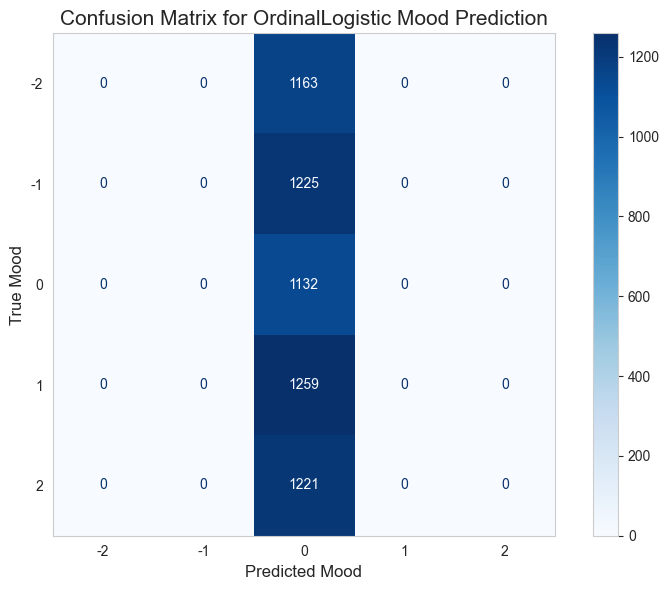

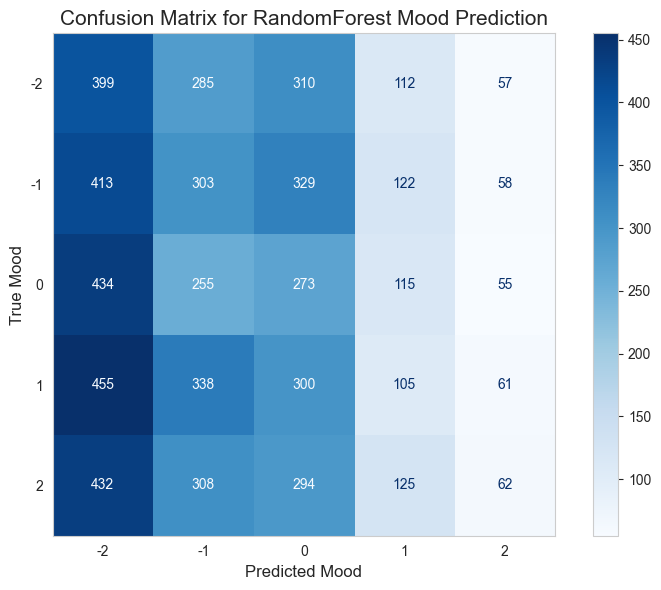

In [159]:
y_pred_ordinal = log_reg_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_ordinal = np.clip(np.round(y_pred_ordinal), -2, 2).astype(int)

def generate_confusion_matrix(y_test, y_pred, model_name):
    # Get unique classes from both test and predicted values
    unique_values = np.unique(np.concatenate([y_test, y_pred]))
    unique_values.sort()
    cm = confusion_matrix(y_test, y_pred, labels=unique_values)
    display_labels = [str(val) for val in unique_values]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')

    plt.title(f'Confusion Matrix for {model_name} Mood Prediction', fontsize=15)
    plt.ylabel('True Mood', fontsize=12)
    plt.xlabel('Predicted Mood', fontsize=12)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return cm

cm_ordinal = generate_confusion_matrix(y_test, y_pred_ordinal, "OrdinalLogistic")
cm_rf = generate_confusion_matrix(y_test, y_pred_rf, "RandomForest")

In [160]:
def generate_performance_metrics(y_test, y_pred, model_name=""):
    score = accuracy_score(y_test, y_pred)
    if model_name:
        print(f"\n=== {model_name} Performance ===")
    print('Model Accuracy:', score)
    print('Classification Report:\n', classification_report(y_test, y_pred, zero_division=0))
    
    return score

y_pred_ordinal = log_reg_model.predict(X_test)
y_pred_ordinal = np.clip(np.round(y_pred_ordinal), -2, 2).astype(int)
generate_performance_metrics(y_test, y_pred_ordinal, "OrdinalLogistic")
generate_performance_metrics(y_test, y_pred_rf, "Random Forest")


=== OrdinalLogistic Performance ===
Model Accuracy: 0.18866666666666668
Classification Report:
               precision    recall  f1-score   support

          -2       0.00      0.00      0.00      1163
          -1       0.00      0.00      0.00      1225
           0       0.19      1.00      0.32      1132
           1       0.00      0.00      0.00      1259
           2       0.00      0.00      0.00      1221

    accuracy                           0.19      6000
   macro avg       0.04      0.20      0.06      6000
weighted avg       0.04      0.19      0.06      6000


=== Random Forest Performance ===
Model Accuracy: 0.19033333333333333
Classification Report:
               precision    recall  f1-score   support

          -2       0.19      0.34      0.24      1163
          -1       0.20      0.25      0.22      1225
           0       0.18      0.24      0.21      1132
           1       0.18      0.08      0.11      1259
           2       0.21      0.05      0.08     

0.19033333333333333

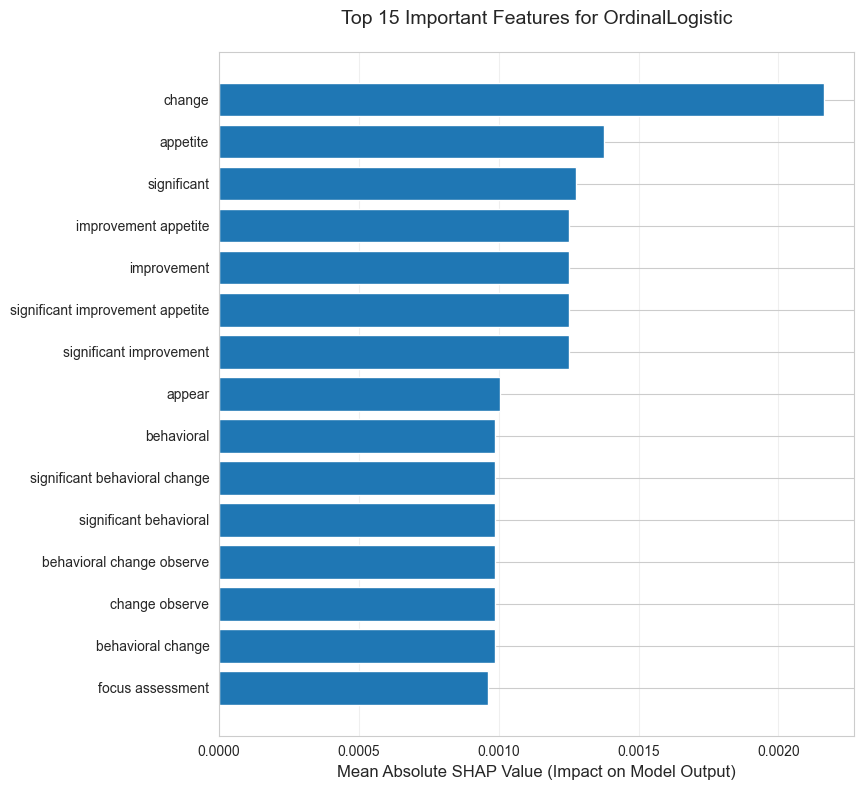

In [161]:
def plot_feature_importance(model, X_train, feature_names, model_name, max_features=15):
    if sparse.issparse(X_train):
        X_train = X_train.toarray()
    
    if str(model.__class__).endswith("OrdinalRidge'>"):
        explainer = shap.LinearExplainer(model, X_train)
    else:
        explainer = shap.TreeExplainer(model)
    
    shap_values = explainer.shap_values(X_train)
    if isinstance(shap_values, list):
        shap_values = np.abs(shap_values).mean(0) 
    else:
        shap_values = np.abs(shap_values)
    
    # Calculate mean importance
    mean_shap = np.mean(shap_values, axis=0)
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': mean_shap
    }).sort_values('importance', ascending=True).tail(max_features) 
    
    plt.figure(figsize=(10, 8))
    bars = plt.barh(
        importance_df['feature'],
        importance_df['importance'],
        color='#1f77b4'
    )
    
    plt.xlabel('Mean Absolute SHAP Value (Impact on Model Output)', fontsize=12)
    plt.title(f'Top {max_features} Important Features for {model_name}', fontsize=14, pad=20)
    plt.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.35) 
    
    plt.show()

plot_feature_importance(log_reg_model, X_train, feature_names, "OrdinalLogistic")

 98%|===================| 29369/30000 [00:21<00:00]        


Analysis for output 1


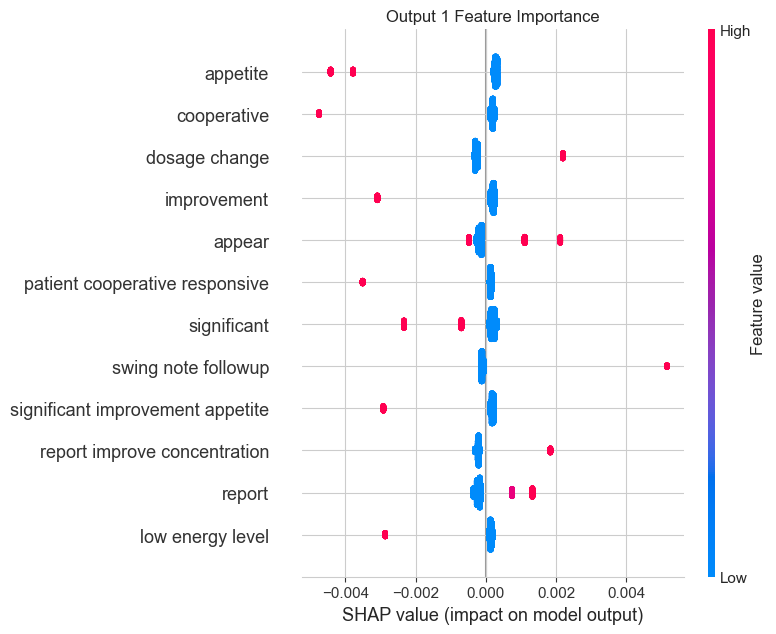


Analysis for output 2


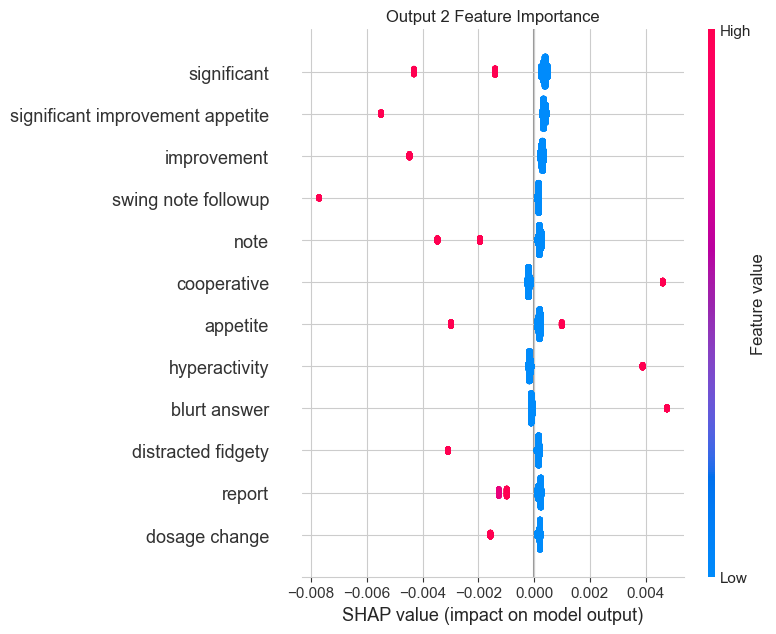


Analysis for output 3


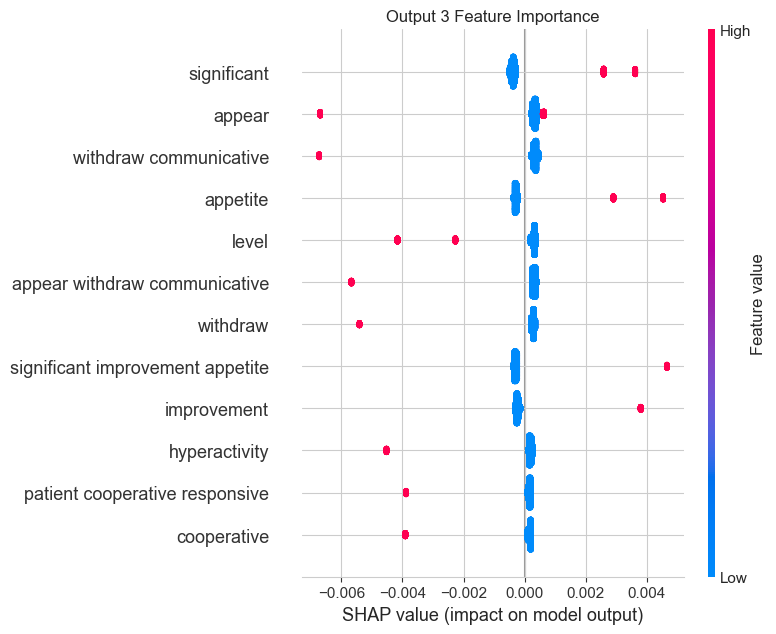


Analysis for output 4


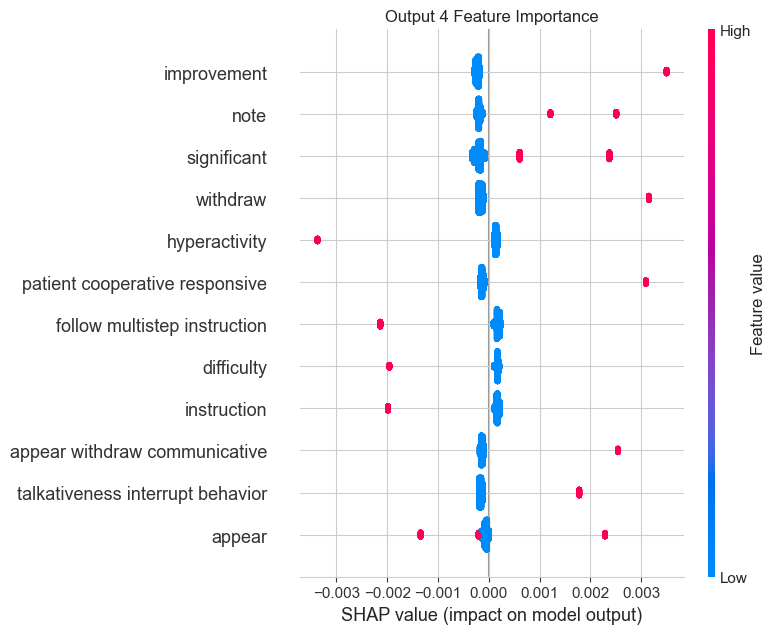


Analysis for output 5


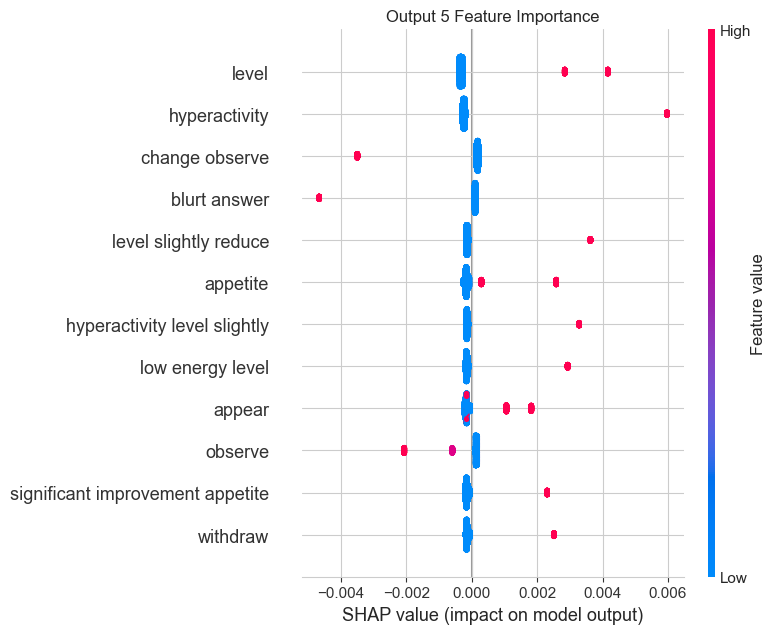

In [162]:
# compute SHAP values
explainer = shap.Explainer(rf_model, X_test, feature_names=feature_names)
shap_values = explainer(X_test)
for output_idx in range(shap_values.shape[-1]):
    print(f"\nAnalysis for output {output_idx+1}")
    shap.summary_plot(shap_values[..., output_idx], X_test, 
                     max_display=12, show=False)
    plt.title(f"Output {output_idx+1} Feature Importance")
    plt.show()